# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable" / "1y"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'vae'

In [5]:
# Load real time series
data_train_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_1y.csv')
data_train_real_numpy = dc(data_train_real_df).to_numpy()

data_test_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_3mo.csv')
data_test_real_numpy = dc(data_test_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8726_12_5_lstm_autoencoder.csv', shape=(8726, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8759_12_5_fc_vae.csv', shape=(8759, 12, 5))

elif syn_data_type == 'jitter':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'jittered_01.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_train_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal train data:\n')
print(data_train_real_df.describe())

print('\n\nreal test data:\n')
print(data_test_real_df.describe())



 syn data:

       traffic_volume           temp        rain_1h       snow_1h  \
count   105108.000000  105108.000000  105108.000000  1.051080e+05   
mean      3148.838149     284.774122       0.000006  7.282879e-08   
std       1568.433179      11.482328       0.001798  1.720454e-05   
min          0.000000     248.318405       0.000000  0.000000e+00   
25%       1950.211853     277.012169       0.000000  0.000000e+00   
50%       3213.790527     285.608795       0.000000  0.000000e+00   
75%       4360.239624     292.805458       0.000000  0.000000e+00   
max      10416.874023     330.338318       0.583064  5.320169e-03   

          clouds_all  
count  105108.000000  
mean       42.894571  
std        29.525214  
min         0.000000  
25%        18.017132  
50%        42.057602  
75%        65.470171  
max       140.194412  


real train data:

       traffic_volume         temp      rain_1h      snow_1h   clouds_all
count     8759.000000  8759.000000  8759.000000  8759.000000  8

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 12,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 500,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(
    data_train_real=data_train_real_numpy, 
    data_test_real=data_test_real_numpy,
    data_syn=data_syn_numpy, 
    hyperparameters=hyperparameters, 
    include_baseline=True, 
    verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  12
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  500
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.17799467115193932 // Train Acc: 0.011405109489051095
Val Loss: 0.13792057511026917 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02619252136031533 // Train Acc: 0.011405109489051095
Val Loss: 0.02818889425629202 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01294557518074221 // Train Acc: 0.011405109489051095
Val Loss: 0.014286062330938876 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009564649145013523 // Train Acc: 0.011405109489051095
Val Loss: 0.010656911595587563 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008451577846171593 // Train Acc: 0.011405109489051095
Val Loss: 0.009094199788866235 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007526742886279431 // Train Acc: 0.011405109489051095
Val Loss: 0.007898219176294172 // Val Acc: 0.0
*

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [00:52<07:56, 52.91s/it]

INFO: Validation loss did not improve in epoch 123
Early stopping after 123 epochs
Epoch: 1
Train Loss: 0.07347066969658336 // Train Acc: 0.011405109489051095
Val Loss: 0.07661422429715886 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.015566260334661734 // Train Acc: 0.011405109489051095
Val Loss: 0.017666862236664575 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011930029498103897 // Train Acc: 0.011405109489051095
Val Loss: 0.013311360065606148 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010483552008377809 // Train Acc: 0.011405109489051095
Val Loss: 0.01147655863657265 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009472924283787227 // Train Acc: 0.011405109489051095
Val Loss: 0.01016294994213454 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008479219892769237

 20%|██        | 2/10 [04:18<19:03, 142.97s/it]

Epoch: 1
Train Loss: 0.26058847030937454 // Train Acc: 0.011405109489051095
Val Loss: 0.19805623440291076 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.027751523229789778 // Train Acc: 0.011405109489051095
Val Loss: 0.03106750950545949 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012452352608479288 // Train Acc: 0.011405109489051095
Val Loss: 0.014041340471628834 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010872691650501025 // Train Acc: 0.011405109489051095
Val Loss: 0.012075259476927492 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009793603291648379 // Train Acc: 0.011405109489051095
Val Loss: 0.010395201125100036 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009086083702362366 // Train Acc: 0.011405109489051095
Val Loss: 0.009257781699381988 // Val Acc: 0.0

 30%|███       | 3/10 [07:44<20:01, 171.61s/it]

Epoch: 1
Train Loss: 0.1906199593769971 // Train Acc: 0.011405109489051095
Val Loss: 0.11572467983590767 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02858628821389301 // Train Acc: 0.011405109489051095
Val Loss: 0.03182912311133217 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012503075453343998 // Train Acc: 0.011405109489051095
Val Loss: 0.013900957987917698 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009483994808588449 // Train Acc: 0.011405109489051095
Val Loss: 0.010476158901035567 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008308734243861434 // Train Acc: 0.011405109489051095
Val Loss: 0.009201973567114156 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007909621815851475 // Train Acc: 0.011405109489051095
Val Loss: 0.008553901666720562 // Val Acc: 0.0
*

 40%|████      | 4/10 [11:13<18:37, 186.21s/it]

Epoch: 1
Train Loss: 0.15702153214110728 // Train Acc: 0.011405109489051095
Val Loss: 0.12353809017633252 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.025953389530879084 // Train Acc: 0.011405109489051095
Val Loss: 0.027969788047758973 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012874764478238584 // Train Acc: 0.011405109489051095
Val Loss: 0.014410507413284743 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01080313926931457 // Train Acc: 0.011405109489051095
Val Loss: 0.011885406517916742 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00962609643614545 // Train Acc: 0.011405109489051095
Val Loss: 0.010404208811986096 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008750727498329442 // Train Acc: 0.011405109489051095
Val Loss: 0.009363432777771616 // Val Acc: 0.0


 50%|█████     | 5/10 [12:23<12:01, 144.30s/it]

INFO: Validation loss did not improve in epoch 171
Early stopping after 171 epochs
Epoch: 1
Train Loss: 0.1484942818400416 // Train Acc: 0.011405109489051095
Val Loss: 0.11603222908589113 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0204930516201187 // Train Acc: 0.011405109489051095
Val Loss: 0.022822709986940026 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011536514103144109 // Train Acc: 0.011405109489051095
Val Loss: 0.012426458018393639 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009546910511817525 // Train Acc: 0.011405109489051095
Val Loss: 0.010064454506123987 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008050418370930193 // Train Acc: 0.011405109489051095
Val Loss: 0.008721632040653597 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00739969616185663 /

 60%|██████    | 6/10 [15:48<11:00, 165.15s/it]

Epoch: 1
Train Loss: 0.3533200718000205 // Train Acc: 0.02281021897810219
Val Loss: 0.23965308823458412 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02760863538668321 // Train Acc: 0.011405109489051095
Val Loss: 0.029260489678777316 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014264194449464227 // Train Acc: 0.011405109489051095
Val Loss: 0.016294362598701435 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011782237524455617 // Train Acc: 0.011405109489051095
Val Loss: 0.013200320882092723 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010666954964586282 // Train Acc: 0.011405109489051095
Val Loss: 0.011753623308750856 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009976197023923597 // Train Acc: 0.011405109489051095
Val Loss: 0.010843890065135545 // Val Acc: 0.0
*

 70%|███████   | 7/10 [19:14<08:55, 178.51s/it]

Epoch: 1
Train Loss: 0.2590277914406501 // Train Acc: 0.0
Val Loss: 0.18107442784479216 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03196434636879032 // Train Acc: 0.011405109489051095
Val Loss: 0.03512113985112485 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012479214340594536 // Train Acc: 0.011405109489051095
Val Loss: 0.01378180568366695 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010866845774389532 // Train Acc: 0.011405109489051095
Val Loss: 0.011929882012362428 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010147670043435246 // Train Acc: 0.011405109489051095
Val Loss: 0.011029640647500534 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009461461274500555 // Train Acc: 0.011405109489051095
Val Loss: 0.0101273882387699 // Val Acc: 0.0
*********************

 80%|████████  | 8/10 [20:10<04:38, 139.27s/it]

INFO: Validation loss did not improve in epoch 134
Early stopping after 134 epochs
Epoch: 1
Train Loss: 0.15105167465678748 // Train Acc: 0.011405109489051095
Val Loss: 0.12019260096884168 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02377727632512794 // Train Acc: 0.011405109489051095
Val Loss: 0.0249082978869624 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01210217933165399 // Train Acc: 0.011405109489051095
Val Loss: 0.013126149821533439 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009138326389616504 // Train Acc: 0.011405109489051095
Val Loss: 0.009901111294953701 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008092164606651304 // Train Acc: 0.011405109489051095
Val Loss: 0.008646484306903885 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007605751924111379 /

 90%|█████████ | 9/10 [23:36<02:40, 160.15s/it]

Epoch: 1
Train Loss: 0.21909921851865674 // Train Acc: 0.011405109489051095
Val Loss: 0.16890074868056484 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02629713809634321 // Train Acc: 0.011405109489051095
Val Loss: 0.02830514933585244 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01194141980134848 // Train Acc: 0.011405109489051095
Val Loss: 0.013067380460116136 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009210547070736133 // Train Acc: 0.011405109489051095
Val Loss: 0.01007516762269113 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00797460641011759 // Train Acc: 0.011405109489051095
Val Loss: 0.008415330701288493 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007289508384835981 // Train Acc: 0.011405109489051095
Val Loss: 0.007383339839768322 // Val Acc: 0.0
***

100%|██████████| 10/10 [24:35<00:00, 147.54s/it]


INFO: Validation loss did not improve in epoch 145
Early stopping after 145 epochs
Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (1741, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.15826724270639353 // Train Acc: 0.014269406392694063
Val Loss: 0.1013856262137944 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.032623045877914994 // Train Acc: 0.014269406392694063
Val Loss: 0.02767664214426821 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014583733759939535 // Train Acc: 0.014269406392694063
Val Loss: 0.011928062746301293 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011668208621327497 // Train Acc: 0.014269406392694063
Val Loss: 0.009345631932162425 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009861394256931734 // Train Acc: 0.014269406392694063
Val Loss: 0.00787950037047267 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008789720133874038 // Train Acc: 0.014269406392694063
Val Loss: 0.007050223839045925 // Val Acc: 0.0
*

 10%|█         | 1/10 [02:49<25:26, 169.61s/it]

Epoch: 1
Train Loss: 0.2974454102076624 // Train Acc: 0.0
Val Loss: 0.1966146393255754 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.049212150080086975 // Train Acc: 0.014269406392694063
Val Loss: 0.04312622855332765 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.020348024201583645 // Train Acc: 0.014269406392694063
Val Loss: 0.016725225890563293 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012959750070445001 // Train Acc: 0.014269406392694063
Val Loss: 0.010259092946282841 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010945714277121744 // Train Acc: 0.014269406392694063
Val Loss: 0.008623469815674153 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0099847762474416 // Train Acc: 0.014269406392694063
Val Loss: 0.007827445860444145 // Val Acc: 0.0
********************

 20%|██        | 2/10 [05:37<22:29, 168.65s/it]

Epoch: 1
Train Loss: 0.10666182377805176 // Train Acc: 0.014269406392694063
Val Loss: 0.06571700088679791 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.027551272650117472 // Train Acc: 0.014269406392694063
Val Loss: 0.023594747263599527 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013193285165005895 // Train Acc: 0.014269406392694063
Val Loss: 0.01066662986678156 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01031897680676589 // Train Acc: 0.014269406392694063
Val Loss: 0.008288982256569646 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009086635048803129 // Train Acc: 0.014269406392694063
Val Loss: 0.007307922111993486 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008563287828338746 // Train Acc: 0.014269406392694063
Val Loss: 0.006812317927621983 // Val Acc: 0.0


 30%|███       | 3/10 [08:24<19:35, 167.94s/it]

Epoch: 1
Train Loss: 0.13154154258980055 // Train Acc: 0.014269406392694063
Val Loss: 0.08581822968342087 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.039915502258495654 // Train Acc: 0.014269406392694063
Val Loss: 0.03430630896579136 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015298682479740686 // Train Acc: 0.014269406392694063
Val Loss: 0.012425338091667402 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011188720701130524 // Train Acc: 0.014269406392694063
Val Loss: 0.009345068837600676 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010004441391519318 // Train Acc: 0.014269406392694063
Val Loss: 0.008382123391228643 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009061278816265773 // Train Acc: 0.014269406392694063
Val Loss: 0.007535877963528037 // Val Acc: 0.0

 40%|████      | 4/10 [11:12<16:47, 167.85s/it]

Epoch: 1
Train Loss: 0.2625840151529402 // Train Acc: 0.0
Val Loss: 0.1633458602496169 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.041419171630383625 // Train Acc: 0.014269406392694063
Val Loss: 0.03600704603913155 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014041723336888367 // Train Acc: 0.014269406392694063
Val Loss: 0.011659961464730176 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011786120661457821 // Train Acc: 0.014269406392694063
Val Loss: 0.009815068500624462 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010586076766650137 // Train Acc: 0.014269406392694063
Val Loss: 0.009045221986757083 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0096167531624632 // Train Acc: 0.014269406392694063
Val Loss: 0.008439801472493194 // Val Acc: 0.0
********************

 50%|█████     | 5/10 [13:59<13:57, 167.49s/it]

Epoch: 1
Train Loss: 0.18661242361992733 // Train Acc: 0.014269406392694063
Val Loss: 0.11742410412566229 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.038301053214563084 // Train Acc: 0.014269406392694063
Val Loss: 0.031836084513501686 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01649926089018277 // Train Acc: 0.014269406392694063
Val Loss: 0.013755534047430212 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011604790222835323 // Train Acc: 0.014269406392694063
Val Loss: 0.009526459174230695 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009239614594591671 // Train Acc: 0.014269406392694063
Val Loss: 0.0075161115986041045 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008401532906222425 // Train Acc: 0.014269406392694063
Val Loss: 0.0066399159798906605 // Val Acc: 0

 60%|██████    | 6/10 [16:46<11:09, 167.48s/it]

Epoch: 1
Train Loss: 0.18643351737835093 // Train Acc: 0.014269406392694063
Val Loss: 0.11389622397043488 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.030091346590248143 // Train Acc: 0.014269406392694063
Val Loss: 0.024944304725663228 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01479290472024618 // Train Acc: 0.014269406392694063
Val Loss: 0.012276745337823575 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011240354529688279 // Train Acc: 0.014269406392694063
Val Loss: 0.009227142766626045 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00917274430319752 // Train Acc: 0.014269406392694063
Val Loss: 0.007416577480564063 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007834753471311845 // Train Acc: 0.014269406392694063
Val Loss: 0.006342957549813119 // Val Acc: 0.0


 70%|███████   | 7/10 [19:33<08:22, 167.38s/it]

Epoch: 1
Train Loss: 0.11294176076543114 // Train Acc: 0.014269406392694063
Val Loss: 0.07678496607325294 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03803110259189589 // Train Acc: 0.014269406392694063
Val Loss: 0.03209651317447424 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014970069955268952 // Train Acc: 0.014269406392694063
Val Loss: 0.013558887664906004 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011370604253931132 // Train Acc: 0.014269406392694063
Val Loss: 0.009703407893803986 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009506984691977603 // Train Acc: 0.014269406392694063
Val Loss: 0.007917071222750979 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008534068338462411 // Train Acc: 0.014269406392694063
Val Loss: 0.006983397575095296 // Val Acc: 0.0


 80%|████████  | 8/10 [22:21<05:34, 167.36s/it]

Epoch: 1
Train Loss: 0.15270298088318138 // Train Acc: 0.014269406392694063
Val Loss: 0.09539959379895167 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03319144436927963 // Train Acc: 0.014269406392694063
Val Loss: 0.028882363726469604 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014964590013903229 // Train Acc: 0.014269406392694063
Val Loss: 0.012661910700527105 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011245040102334498 // Train Acc: 0.014269406392694063
Val Loss: 0.00906460277990184 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010105051747714616 // Train Acc: 0.014269406392694063
Val Loss: 0.00800822496583516 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00951536700233698 // Train Acc: 0.014269406392694063
Val Loss: 0.007490597013384104 // Val Acc: 0.0
**

 90%|█████████ | 9/10 [25:08<02:47, 167.27s/it]

Epoch: 1
Train Loss: 0.11858649208257187 // Train Acc: 0.014269406392694063
Val Loss: 0.08077001273632049 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.026198538828249934 // Train Acc: 0.014269406392694063
Val Loss: 0.02480962930077856 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01578345556252266 // Train Acc: 0.014269406392694063
Val Loss: 0.015143649068407037 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01214633400118208 // Train Acc: 0.014269406392694063
Val Loss: 0.010860855526036836 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009983462610571182 // Train Acc: 0.014269406392694063
Val Loss: 0.00842243702235547 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008846783850524897 // Train Acc: 0.014269406392694063
Val Loss: 0.007233220584351908 // Val Acc: 0.0
**

100%|██████████| 10/10 [27:55<00:00, 167.52s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.0832499596183975 // Train Acc: 0.0
Val Loss: 0.0479745169932192 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008810879013046079 // Train Acc: 0.0
Val Loss: 0.008105050831694495 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0007965566148422233 // Train Acc: 0.04280821917808219
Val Loss: 0.0007457108273890546 // Val Acc: 0.056818181818181816
**************************************************
Epoch: 31
Train Loss: 0.00038912115741114995 // Train Acc: 0.48562012078362055
Val Loss: 0.00037238692219199784 // Val Acc: 0.7007575757575757
**************************************************
Epoch: 41
Train Loss: 0.00022233534061703958 // Train Acc: 0.7567388422448077
Val Loss: 0.0002303348590926775 // Val Acc: 1.0984848484848484
**************************************************
Epoch: 51
Train Loss: 0.00019625106702301413 // Train Acc: 0.7424694358521137
Val Loss: 0.00020464709470450

 10%|█         | 1/10 [02:47<25:10, 167.84s/it]

Epoch: 1
Train Loss: 0.1283389860806672 // Train Acc: 0.2996575342465753
Val Loss: 0.08160961344838143 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.004704856218081223 // Train Acc: 0.0
Val Loss: 0.003178531638431278 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0006517680360803797 // Train Acc: 0.0
Val Loss: 0.0006155784263021566 // Val Acc: 0.056818181818181816
**************************************************
Epoch: 31
Train Loss: 0.00029926457945746474 // Train Acc: 0.4570813079982324
Val Loss: 0.000277009888139384 // Val Acc: 0.7007575757575757
**************************************************
Epoch: 41
Train Loss: 0.0002185092306298259 // Train Acc: 0.599775371925173
Val Loss: 0.00020838877773547376 // Val Acc: 0.8143939393939393
**************************************************
Epoch: 51
Train Loss: 0.00018434864795460051 // Train Acc: 0.6853918102813374
Val Loss: 0.00018023590634005482 

 20%|██        | 2/10 [05:35<22:20, 167.55s/it]

Epoch: 1
Train Loss: 0.05916653189076681 // Train Acc: 0.0
Val Loss: 0.03710947009650144 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.003026607125831691 // Train Acc: 0.0
Val Loss: 0.002118645121597431 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0005526861963159996 // Train Acc: 0.09988584474885845
Val Loss: 0.0005305305816529488 // Val Acc: 0.22727272727272727
**************************************************
Epoch: 31
Train Loss: 0.00029028543412258005 // Train Acc: 0.599775371925173
Val Loss: 0.0002865490699398585 // Val Acc: 0.7575757575757576
**************************************************
Epoch: 41
Train Loss: 0.00022632846859994463 // Train Acc: 0.7424694358521137
Val Loss: 0.0002294070666804063 // Val Acc: 0.928030303030303
**************************************************
Epoch: 51
Train Loss: 0.00019488357462732603 // Train Acc: 0.7852776550301959
Val Loss: 0.00020209825809367678

 30%|███       | 3/10 [08:22<19:31, 167.42s/it]

Epoch: 1
Train Loss: 0.09220748068126913 // Train Acc: 0.0
Val Loss: 0.058755959434942766 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.001553028431502022 // Train Acc: 0.0
Val Loss: 0.000987608407475901 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00033455744228771245 // Train Acc: 0.32865665046398584
Val Loss: 0.0003195671494309367 // Val Acc: 0.625
**************************************************
Epoch: 31
Train Loss: 0.0002344633515320344 // Train Acc: 0.6568529974959493
Val Loss: 0.00024391036872244015 // Val Acc: 0.8143939393939393
**************************************************
Epoch: 41
Train Loss: 0.00020103825725477877 // Train Acc: 0.7139306230667256
Val Loss: 0.00021133283841085027 // Val Acc: 0.9848484848484848
**************************************************
Epoch: 51
Train Loss: 0.00018261331639871358 // Train Acc: 0.7567388422448077
Val Loss: 0.00019117347374875945 // Val A

 40%|████      | 4/10 [11:09<16:43, 167.23s/it]

Epoch: 1
Train Loss: 0.11993181788826097 // Train Acc: 0.014269406392694063
Val Loss: 0.07118974429639903 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.012892119035754166 // Train Acc: 0.0
Val Loss: 0.011995297636498104 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0011022303424314192 // Train Acc: 0.0
Val Loss: 0.0009571129149249331 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00031382941316518735 // Train Acc: 0.5569671527470909
Val Loss: 0.0003195583804468201 // Val Acc: 0.8712121212121212
**************************************************
Epoch: 41
Train Loss: 0.00022940644082059387 // Train Acc: 0.7710082486375018
Val Loss: 0.00023170827639246868 // Val Acc: 1.0416666666666665
**************************************************
Epoch: 51
Train Loss: 0.00019861386570142322 // Train Acc: 0.8280858742082781
Val Loss: 0.0001985347586345266 // Val Acc: 

 50%|█████     | 5/10 [13:57<13:57, 167.47s/it]

Epoch: 1
Train Loss: 0.11970399913790564 // Train Acc: 0.2711187214611872
Val Loss: 0.08062426034699786 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.00847943241550634 // Train Acc: 0.0
Val Loss: 0.007497320146384564 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0006382733690563045 // Train Acc: 0.014269406392694063
Val Loss: 0.0006126093000850894 // Val Acc: 0.056818181818181816
**************************************************
Epoch: 31
Train Loss: 0.0002732151267692855 // Train Acc: 0.5426977463543968
Val Loss: 0.00025032274398571725 // Val Acc: 0.7007575757575757
**************************************************
Epoch: 41
Train Loss: 0.00018745582945725654 // Train Acc: 0.8851634997790543
Val Loss: 0.00018712803470076654 // Val Acc: 1.1553030303030303
**************************************************
Epoch: 51
Train Loss: 0.00016791658845042266 // Train Acc: 0.9565105317425247
Val Loss: 0.0

 60%|██████    | 6/10 [16:45<11:10, 167.57s/it]

Epoch: 1
Train Loss: 0.08736156752188456 // Train Acc: 0.0
Val Loss: 0.05282245444303209 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01020467016828931 // Train Acc: 0.0
Val Loss: 0.009101379434154792 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.000508576483302537 // Train Acc: 0.17123287671232876
Val Loss: 0.0004909391382666812 // Val Acc: 0.2840909090909091
**************************************************
Epoch: 31
Train Loss: 0.0002585860343289043 // Train Acc: 0.6283141847105612
Val Loss: 0.00025187827824001114 // Val Acc: 0.7575757575757576
**************************************************
Epoch: 41
Train Loss: 0.0002104888507550408 // Train Acc: 0.8708940933863603
Val Loss: 0.00021035035923970018 // Val Acc: 1.0416666666666665
**************************************************
Epoch: 51
Train Loss: 0.000191055578190289 // Train Acc: 0.8994329061717484
Val Loss: 0.00019176112638722936 //

 70%|███████   | 7/10 [19:32<08:22, 167.44s/it]

Epoch: 1
Train Loss: 0.1623289047242844 // Train Acc: 0.45662100456621
Val Loss: 0.10024597509340806 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013681835958470492 // Train Acc: 0.0
Val Loss: 0.01288024334406311 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0024104441880763053 // Train Acc: 0.0
Val Loss: 0.002164010455916551 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0006529810252603671 // Train Acc: 0.04280821917808219
Val Loss: 0.0006378429576712237 // Val Acc: 0.11363636363636363
**************************************************
Epoch: 41
Train Loss: 0.0004419662573584249 // Train Acc: 0.21450139932243334
Val Loss: 0.00042316427068065174 // Val Acc: 0.3409090909090909
**************************************************
Epoch: 51
Train Loss: 0.0002565320678742084 // Train Acc: 0.6140447783178671
Val Loss: 0.00025287841192700645 // Val Acc: 0.8712

 80%|████████  | 8/10 [22:19<05:34, 167.43s/it]

Epoch: 1
Train Loss: 0.029778884187953113 // Train Acc: 0.0
Val Loss: 0.02215068516406146 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.005416316301327998 // Train Acc: 0.0
Val Loss: 0.004383888561278582 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00041019439111999556 // Train Acc: 0.24304021210782148
Val Loss: 0.00039739704463334586 // Val Acc: 0.3977272727272727
**************************************************
Epoch: 31
Train Loss: 0.00025306427411439503 // Train Acc: 0.6425835911032552
Val Loss: 0.0002477024655408141 // Val Acc: 0.8712121212121212
**************************************************
Epoch: 41
Train Loss: 0.00020523025762498673 // Train Acc: 0.8423552806009721
Val Loss: 0.00020731299360208637 // Val Acc: 1.1553030303030303
**************************************************
Epoch: 51
Train Loss: 0.00018344297731674242 // Train Acc: 0.9279717189571365
Val Loss: 0.000187237753297

 90%|█████████ | 9/10 [25:06<02:47, 167.35s/it]

Epoch: 1
Train Loss: 0.15109693534570198 // Train Acc: 0.8276255707762558
Val Loss: 0.09135310141877695 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0009813603919029202 // Train Acc: 0.0
Val Loss: 0.0008581628806000067 // Val Acc: 0.056818181818181816
**************************************************
Epoch: 21
Train Loss: 0.00043376690131871534 // Train Acc: 0.24304021210782148
Val Loss: 0.0004091805079951882 // Val Acc: 0.3977272727272727
**************************************************
Epoch: 31
Train Loss: 0.0002673828834362145 // Train Acc: 0.585505965532479
Val Loss: 0.0002542767747813328 // Val Acc: 0.8143939393939393
**************************************************
Epoch: 41
Train Loss: 0.0001980804541354497 // Train Acc: 0.7710082486375018
Val Loss: 0.0001972597245846621 // Val Acc: 1.0416666666666665
**************************************************
Epoch: 51
Train Loss: 0.0001760050325830399 // Train Acc: 0.8280858742082781


100%|██████████| 10/10 [27:54<00:00, 167.43s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.03524293081433832 // Train Acc: 0.0
Val Loss: 0.03766020864029141 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.003710189374125721 // Train Acc: 0.1083485401459854
Val Loss: 0.007497680938446566 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0028556895168369845 // Train Acc: 0.18818430656934307
Val Loss: 0.005731261037427056 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0025744356495044857 // Train Acc: 0.24520985401459855
Val Loss: 0.0050981677931678645 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.002292575272950293 // Train Acc: 0.4676094890510949
Val Loss: 0.004451349654974525 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.002053082295044516 // Train Acc: 0.6101733576642335
Val Loss: 0.0039567669189315945 // Val Acc: 0.0
*******************

 10%|█         | 1/10 [03:27<31:07, 207.46s/it]

INFO: Validation loss did not improve in epoch 261
Early stopping after 261 epochs
Epoch: 1
Train Loss: 0.037162658252012336 // Train Acc: 0.0
Val Loss: 0.035018744001932 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0035922898261467537 // Train Acc: 0.10264598540145986
Val Loss: 0.007176968447097084 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0028187740918858162 // Train Acc: 0.23380474452554745
Val Loss: 0.005693240645889412 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0026204515071471058 // Train Acc: 0.2908302919708029
Val Loss: 0.005271532059208874 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0024870412622064984 // Train Acc: 0.41058394160583944
Val Loss: 0.004988036135567681 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00231799501579435 // Train Acc: 0.5

 20%|██        | 2/10 [10:04<42:31, 318.98s/it]

Epoch: 1
Train Loss: 0.02521656423868326 // Train Acc: 0.0
Val Loss: 0.03380404286743963 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.004010818098441984 // Train Acc: 0.34215328467153283
Val Loss: 0.008024969295708133 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0023471935805203952 // Train Acc: 0.541742700729927
Val Loss: 0.004790902240475749 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0020397574766732353 // Train Acc: 0.4904197080291971
Val Loss: 0.004134193401756313 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0019085745999443938 // Train Acc: 0.4733120437956204
Val Loss: 0.003808112650671426 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0018178821988362372 // Train Acc: 0.4219890510948905
Val Loss: 0.003563778652973911 // Val Acc: 0.0
*********************

 30%|███       | 3/10 [13:39<31:40, 271.49s/it]

INFO: Validation loss did not improve in epoch 271
Early stopping after 271 epochs
Epoch: 1
Train Loss: 0.041952796059449876 // Train Acc: 0.0
Val Loss: 0.03272356268237619 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0038163356778163457 // Train Acc: 0.011405109489051095
Val Loss: 0.007869357048013411 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.002640034847256148 // Train Acc: 0.2166970802919708
Val Loss: 0.005291328481261563 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.002180570447852497 // Train Acc: 0.38207116788321166
Val Loss: 0.004183816672165823 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0019707584629197737 // Train Acc: 0.4562043795620438
Val Loss: 0.0038459483595729314 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0018789881685229606 // Train Acc: 

 40%|████      | 4/10 [18:50<28:43, 287.29s/it]

INFO: Validation loss did not improve in epoch 392
Early stopping after 392 epochs
Epoch: 1
Train Loss: 0.055594662000445556 // Train Acc: 0.0
Val Loss: 0.03905401658266783 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.003553007524668742 // Train Acc: 0.02281021897810219
Val Loss: 0.007081613252761171 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.002804754933586215 // Train Acc: 0.16537408759124086
Val Loss: 0.0055690604015527405 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0024600198205113693 // Train Acc: 0.41628649635036497
Val Loss: 0.004793846959193402 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.002177186784078282 // Train Acc: 0.5759580291970803
Val Loss: 0.004107745860785465 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0020340170579793864 // Train Acc: 0

 50%|█████     | 5/10 [20:38<18:33, 222.61s/it]

INFO: Validation loss did not improve in epoch 136
Early stopping after 136 epochs
Epoch: 1
Train Loss: 0.08046283500513783 // Train Acc: 0.0
Val Loss: 0.035671315046356004 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.003772425384612934 // Train Acc: 0.017107664233576642
Val Loss: 0.0077097877784741715 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0029552551620267245 // Train Acc: 0.08553832116788321
Val Loss: 0.005986584045732503 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.002690154437881123 // Train Acc: 0.20529197080291972
Val Loss: 0.00539132217904005 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0025074301242070393 // Train Acc: 0.24520985401459855
Val Loss: 0.004948702815454453 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0023157858206078164 // Train Acc:

 60%|██████    | 6/10 [25:59<17:03, 255.79s/it]

INFO: Validation loss did not improve in epoch 404
Early stopping after 404 epochs
Epoch: 1
Train Loss: 0.15638694388071334 // Train Acc: 0.19388686131386862
Val Loss: 0.0444718576310312 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.004349940747886609 // Train Acc: 0.011405109489051095
Val Loss: 0.008589350344503628 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0026116905942715173 // Train Acc: 0.34215328467153283
Val Loss: 0.005155600348884678 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0022511354743545097 // Train Acc: 0.479014598540146
Val Loss: 0.004301270261160372 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0021548191208591435 // Train Acc: 0.5018248175182481
Val Loss: 0.004104151280925554 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0021129042887858395 /

 70%|███████   | 7/10 [30:51<13:23, 267.79s/it]

INFO: Validation loss did not improve in epoch 368
Early stopping after 368 epochs
Epoch: 1
Train Loss: 0.06874902631380479 // Train Acc: 0.0
Val Loss: 0.0407442320138216 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0038769442234543087 // Train Acc: 0.06843065693430657
Val Loss: 0.007776101801188334 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0028425122393052143 // Train Acc: 0.13686131386861314
Val Loss: 0.00562485953902497 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.002493451930796872 // Train Acc: 0.2908302919708029
Val Loss: 0.00486632767612772 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.002136440482375617 // Train Acc: 0.5588503649635036
Val Loss: 0.004210144188939868 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.002062952462743639 // Train Acc: 0.58166

 80%|████████  | 8/10 [35:41<09:09, 274.88s/it]

INFO: Validation loss did not improve in epoch 366
Early stopping after 366 epochs
Epoch: 1
Train Loss: 0.04848554669148594 // Train Acc: 0.0
Val Loss: 0.03411115607356324 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.003380373600521125 // Train Acc: 0.005702554744525547
Val Loss: 0.006748695874942795 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0028292976125038525 // Train Acc: 0.07413321167883212
Val Loss: 0.005575591602417476 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.002605149709288393 // Train Acc: 0.2166970802919708
Val Loss: 0.005101420605034732 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.002429468279291687 // Train Acc: 0.302235401459854
Val Loss: 0.004760807030834258 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0022710526476803885 // Train Acc: 0.30

 90%|█████████ | 9/10 [42:17<05:12, 312.78s/it]

Epoch: 1
Train Loss: 0.0865845432943481 // Train Acc: 0.0
Val Loss: 0.03904098020318676 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0038862139955086524 // Train Acc: 0.02281021897810219
Val Loss: 0.007961414641399375 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0029281081183963067 // Train Acc: 0.09124087591240876
Val Loss: 0.005874894922325278 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.002695151839109374 // Train Acc: 0.19958941605839417
Val Loss: 0.005349962958408629 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0025587189806187413 // Train Acc: 0.21099452554744524
Val Loss: 0.005022937808569302 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0024143500031375905 // Train Acc: 0.25661496350364965
Val Loss: 0.004649845342261388 // Val Acc: 0.0
*****************

100%|██████████| 10/10 [47:25<00:00, 284.54s/it]

INFO: Validation loss did not improve in epoch 387
Early stopping after 387 epochs


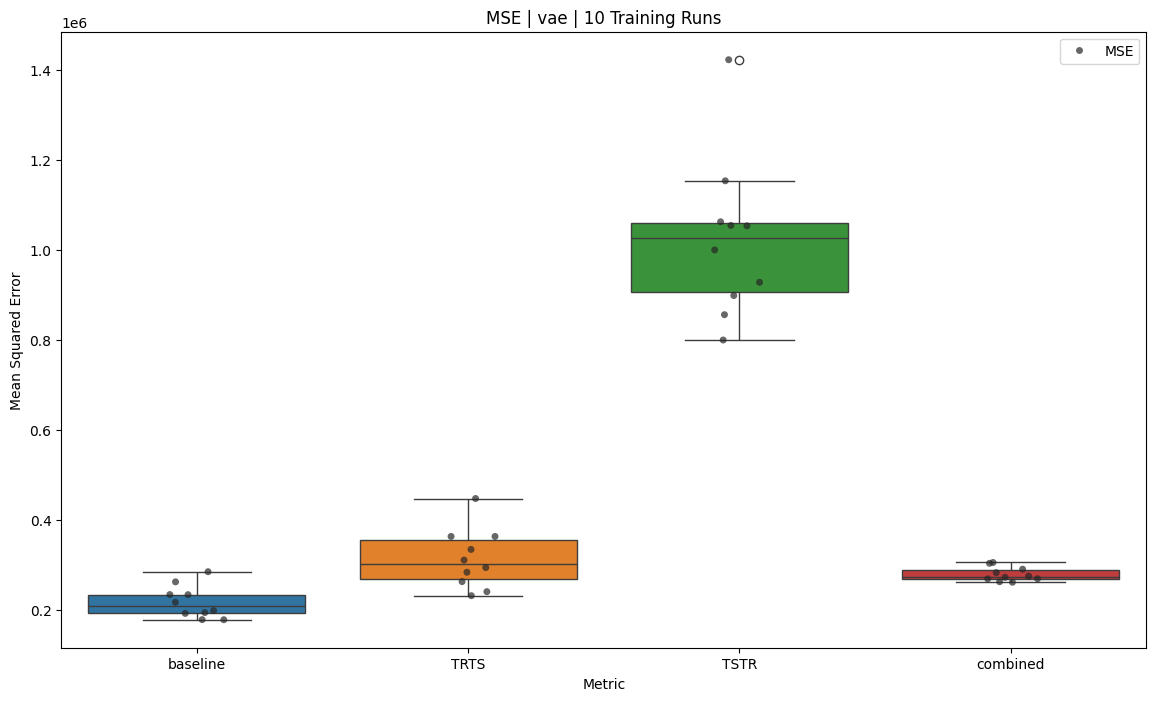

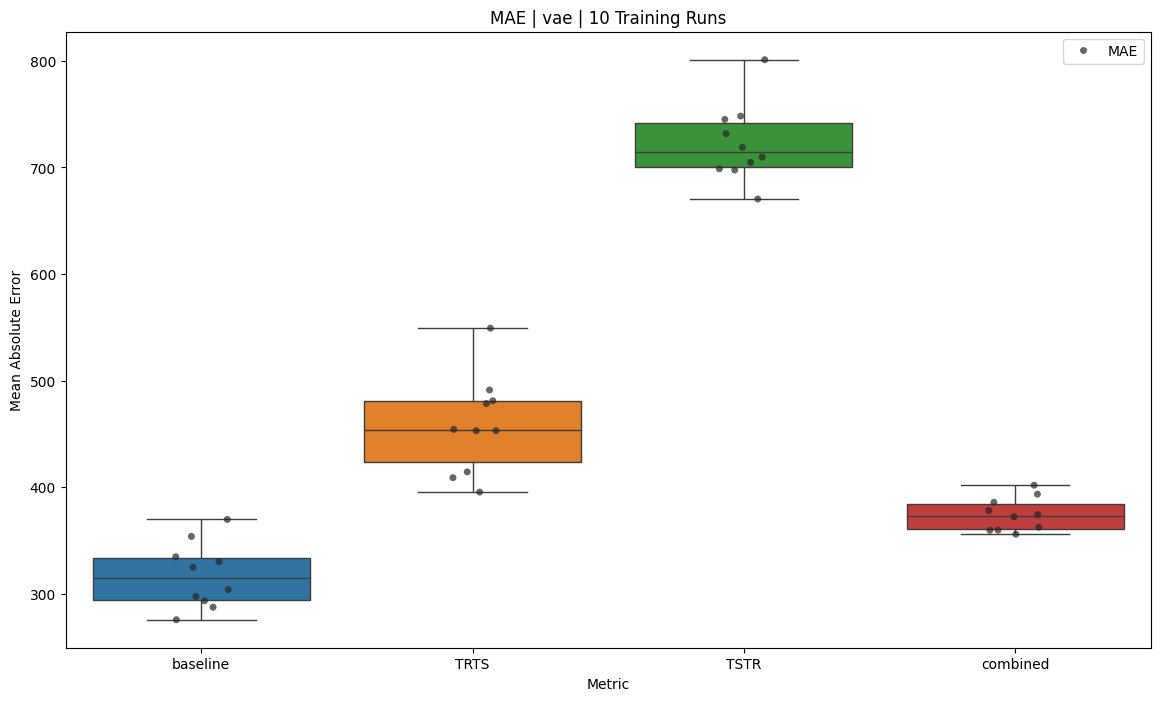

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

In [9]:
0.2*1e06

200000.0